<a href="https://colab.research.google.com/github/graille/ITR315-deep-telecom/blob/master/5-%20Neural%20based%20channel%20decoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural-based channel decoders


## 1. Prerequisites:  

The purpose of this part of the work is to compare the BER of both a pre-trained neural decoder and the MAP decoder for a Polar code over an AWGN channel. 

In order to develop a neural based channel decoder you will need: 

- A communication chain which implements the polar code and its MAP decoder (under python)
- A working keras environment with the proper backend Tensorflow 


## 2. Training dataset and training:  

In order to train the neural network, you need to provide it with both: 
- Input sequences: the received $y^n$
- Label sequences (or targets) : the transmitted $u^k$

In order for the neural decoder to be able to recover the original information words, i.e., $u^k$, the neural decoder needs to be trained over all possible $u^k$ and therefore, all posssible codewords $c^n$. Thus, the label sequences need to cover all possibly transmitted sequences. 

The labels can be coded in two different manners: 
- Array representation: the output of the neural network is a vector of size k, which outputs for each bit $i \in [1:k]$, a possible value 0 or 1. . 
- One hot representation: the output of the neural networ is a vector of size $2^k$ which outputs $1$ only at the index of the information word transmitted, and 0 everywhere else. 

Question: In practice, the output of a neural network is never binary, but it rather has a soft value $ \in [0:1]$. Depending on the type of the network, two possible output activation functions can be used in order to output these soft values: sigmoid or softmax. Which function should we use for either strategies? 

In this project, we will use one-hot representations. 

## 3. Testing: 
Once the neural network is trained, you can test it in the communication chain you implemented before. 

## 4. Design meta-parameters: 

The performances of the neural decoder will be strongly related to the metaparameters chosen during training. 

Try and assess the effect of the different design metaparameters: 

- Training epochs
- Number of hidden layers
- Number of neurons per layer
- Activation functions
- Training SNR 
- Optimizer 
- Loss function: mse, crossentropy 


In [ ]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber, get_fec_matrix

# Configuration
MODULATION = 'BPSK'
G = get_fec_matrix('POLAR_8_16')

# Initialization
transmitter = Transmitter(MODULATION, G)
channel = AWGNChannel(MODULATION, G)
receiver = Receiver(MODULATION, G, ReceiverMode.MAP)


if __name__ == '__main__':
    t = time.time()
    # receiver.block_elements contains all possible u^k (labels)
    # receiver.block_coded_elements contains all possible codewords c^n
    
    k = np.size(G, 0)
    n = np.size(G, 1)
    
    EbN0 = 1 # in dB, SNR for the std to train with the Gaussian layer
    noise_std = np.sqrt(0.5*(n/k)*(1 / transmitter.BPS)*(1/10**(EbN0/10)))
    print(f"Noise std : {noise_std}")
    
    # Create model
    # We are working with probability, to have sum(s_i) = 1 at the output, we use a softmax instead of a sigmoid activation function
    # Because we are using a hit representation, we use a 
    hot_model=Sequential()
    hot_model.add(Dense(20*2**k, activation='relu', input_dim=n))
    hot_model.add(Dense(2**k, activation='softmax'))
            
    
    noisy_model=Sequential()
    noisy_model.add(GaussianNoise(noise_std, input_shape=(n,)))
    noisy_model.add(hot_model)
    
    noisy_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print(noisy_model.summary())
    
    # Create labels for hot representation
    labels = []
    for i in range(2**k):
        labels.append(np.zeros(2**k))
        labels[-1][i] = 1
    
    noisy_history = noisy_model.fit(
        np.array(receiver.block_coded_elements), 
        np.array(labels), 
        epochs=20*10**3, 
        verbose=2
    )
    #noisy_model.save('networks/decoder.h5')
    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')


Streaming output truncated to the last 5000 lines.
 - 0s - loss: 0.7731 - acc: 0.7812
Epoch 1512/20000
 - 0s - loss: 0.7927 - acc: 0.7812
Epoch 1513/20000
 - 0s - loss: 0.8061 - acc: 0.7500
Epoch 1514/20000
 - 0s - loss: 0.8714 - acc: 0.7266
Epoch 1515/20000
 - 0s - loss: 0.8510 - acc: 0.7656
Epoch 1516/20000
 - 0s - loss: 0.8203 - acc: 0.7344
Epoch 1517/20000
 - 0s - loss: 0.7864 - acc: 0.7344
Epoch 1518/20000
 - 0s - loss: 0.7720 - acc: 0.7891
Epoch 1519/20000
 - 0s - loss: 0.8512 - acc: 0.7461
Epoch 1520/20000
 - 0s - loss: 0.6286 - acc: 0.7539
Epoch 1521/20000
 - 0s - loss: 0.7928 - acc: 0.7422
Epoch 1522/20000
 - 0s - loss: 0.7800 - acc: 0.7656
Epoch 1523/20000
 - 0s - loss: 0.7124 - acc: 0.7695
Epoch 1524/20000
 - 0s - loss: 0.8474 - acc: 0.7188
Epoch 1525/20000
 - 0s - loss: 0.6766 - acc: 0.7930
Epoch 1526/20000
 - 0s - loss: 0.7234 - acc: 0.7344
Epoch 1527/20000
 - 0s - loss: 0.8129 - acc: 0.7461
Epoch 1528/20000
 - 0s - loss: 0.8596 - acc: 0.7617
Epoch 1529/20000
 - 0s - loss:

In [ ]:
noisy_model.save('networks/decoder.h5')

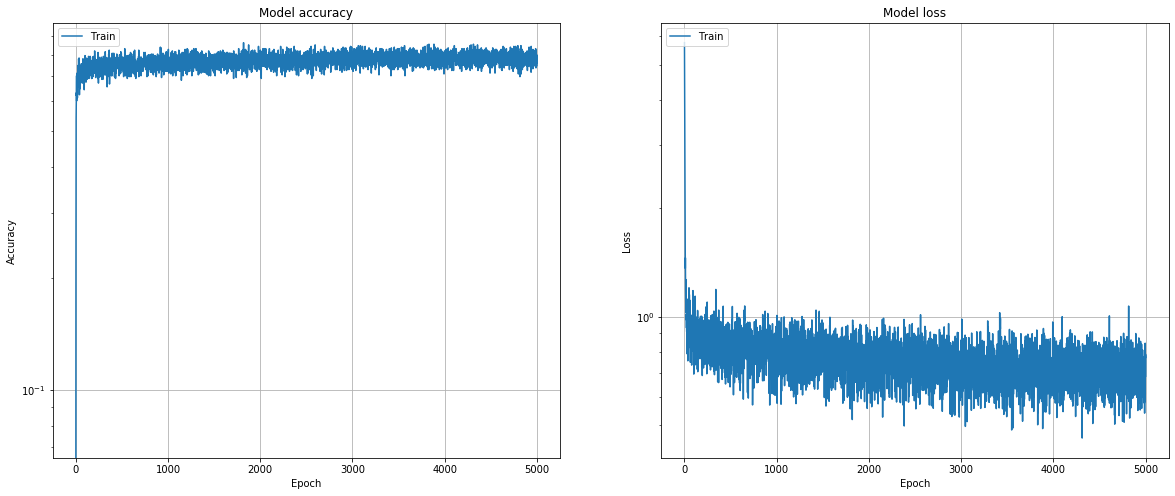

In [12]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)
plt.grid()
plt.plot(noisy_history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(122)
plt.grid()
plt.plot(noisy_history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.yscale('log')
# plt.subplots_adjust(wspace = 0.5)

Start EbN0 1/20 -15.0
Start EbN0 2/20 -13.789473684210526
Start EbN0 3/20 -12.578947368421053
Start EbN0 4/20 -11.368421052631579
Start EbN0 5/20 -10.157894736842106
Start EbN0 6/20 -8.947368421052632
Start EbN0 7/20 -7.7368421052631575
Start EbN0 8/20 -6.526315789473685
Start EbN0 9/20 -5.315789473684211
Start EbN0 10/20 -4.105263157894736
Start EbN0 11/20 -2.8947368421052637
Start EbN0 12/20 -1.6842105263157894
Start EbN0 13/20 -0.47368421052631504
Start EbN0 14/20 0.7368421052631575
Start EbN0 15/20 1.94736842105263
Start EbN0 16/20 3.157894736842106
Start EbN0 17/20 4.368421052631579
Start EbN0 18/20 5.578947368421051
Start EbN0 19/20 6.789473684210527
Start EbN0 20/20 8.0


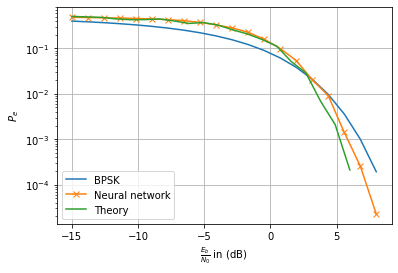

Elapsed : 61.24 s


In [17]:
import time

EbN0dBs = np.linspace(-15, 8, 20)

def channel_fnt(b, EbN0dB):
    c = transmitter.transmit(b)
    d = channel.process(c, EbN0dB)

    # Create blocks
    b_r = noisy_model.predict(np.array(np.split(d, len(d) // transmitter.block_coded_length)))
    
    b_r = np.array(list(map(lambda x: receiver.block_elements[np.argmax(x)], b_r)))
    b_r = b_r.flatten()

    return b_r, c, d

if __name__ == '__main__':
    t = time.time()
    BER = ber_performance(
        EbN0dBs,
        channel_fnt,
        np.size(G, 0) * 5000,
        80
    )
    
    [EbN0dBs_C, BER_C] = np.loadtxt('outputs/BER_G_MAP.csv', delimiter=',')
    
    # Plot results
    plt.figure()
    show_ber(MODULATION, EbN0dBs, BER)
    plt.plot(EbN0dBs_C, BER_C)
    plt.legend(['BPSK', 'Neural network', 'Map algorithm'])
    plt.show()
    
    np.savetxt('outputs/BER_G_NEURAL.csv', [np.array(EbN0dBs), np.array(BER)], delimiter=',')
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')